In [6]:
import fasttext
import pandas as pd
from tqdm.auto import tqdm
import joblib
import scipy
import numpy as np
from sklearn.metrics import classification_report
from razdel import tokenize

from string import punctuation
punct = punctuation+'«»—…“”*–'

## Загружаем модель

In [9]:
model_f = fasttext.load_model("../model-20-min-freq-3.bin")

In [10]:
model_f.get_word_vector("samsung")

array([-5.9325463e-01,  2.4429931e-01,  3.2640547e-01,  1.0844889e-01,
       -3.2271585e-01,  5.3177649e-01, -2.6891569e-02, -2.8868619e-01,
        1.0027807e+00, -2.0299125e-01,  1.9064834e-04, -6.4409119e-01,
       -5.4105371e-01, -2.5627661e-01,  4.6106376e-02, -6.5823066e-01,
        3.0189078e-02,  2.8437024e-01, -3.3804491e-01, -2.1494141e-01,
       -5.9019145e-02,  2.3765634e-01,  3.4469384e-01, -8.3294794e-02,
       -1.6686738e-01, -3.6758831e-01, -1.5896413e-01,  4.8742437e-01,
        2.1384589e-01, -5.2032709e-01,  9.7225420e-02,  3.1522584e-01,
        4.3548375e-02, -2.5610849e-01, -5.8411008e-01, -8.2148217e-02,
       -4.4109982e-01,  6.9937551e-01, -2.2712652e-01, -9.2215419e-02,
        6.3698769e-02, -2.4544959e-01,  2.3396060e-01,  1.5268685e-01,
        2.9772466e-01,  2.3924631e-01,  4.0799943e-01,  6.6718645e-02,
        4.3528631e-01,  5.4900938e-01, -5.3673297e-01,  2.2726862e-01,
       -6.7768580e-01,  2.2655195e-01, -1.0972178e-01,  2.0957486e-01,
      

# Заранее соберем эмбеддинги слов тестовой выборки

In [11]:
df = pd.read_csv("../../classification/test.tsv", sep="\t")

In [12]:
df.head()

,query,pair_id,prev_query,tag,binary_tag
0,iphone 7,0,iphone 8,2,1
1,iphone 8 plus,1,iphone 7 plus,2,1
2,детская кроватка,2,детская кровать,1,1
3,iphone 8,3,айфон 8,1,1
4,запрет на рег действия,4,запрет на регистрационные действия,1,1


In [13]:
def tokenize_query(query):
    line = query.strip()
    tokens = list(tokenize(line))
    tokens = [_.text.lower() for _ in tokens]         
    tokens = [i for i in tokens if i not in punct]
    return tokens

In [14]:
queries = df[["prev_query", "query"]].values.tolist()

In [15]:
tokens = []
for i in queries:
    tokens += tokenize_query(i[0])
    tokens += tokenize_query(i[1])

In [16]:
tok2vec = {}
for i in tqdm(tokens):
    tok2vec[i] = model_f.get_word_vector(i)

In [17]:
len(tok2vec)

1883

## Обозначим функцию косинусной близости

In [18]:
def similarity(vec1, vec2):
    return 1 - scipy.spatial.distance.cosine(vec1, vec2)

In [19]:
similarity(model_f.get_sentence_vector("холодильник в аристон"), model_f.get_sentence_vector("холодильник indesit"))

0.8306529521942139

In [20]:
similarity(model_f.get_sentence_vector("подольск"), model_f.get_sentence_vector("щёлково город"))

0.5587334036827087

## Тестируем модель 1: косинусная близость между векторами, аггрегированными fastText (среднее по векторам слов с регуляризацией)

In [21]:
similarities = []
for q1, q2 in tqdm(queries):
    similarities.append(similarity(model_f.get_sentence_vector(q1), model_f.get_sentence_vector(q2)))

In [22]:
similarities[-15:]

[0.5930640697479248,
 0.552237868309021,
 0.23370395600795746,
 0.46538081765174866,
 0.6069199442863464,
 0.16137760877609253,
 0.3445148468017578,
 0.7143924832344055,
 0.4846670627593994,
 0.31329649686813354,
 0.5587334036827087,
 0.7715017199516296,
 0.6263378858566284,
 0.3161330223083496,
 0.321907103061676]

In [24]:
df["fasttext_20_3_cos"] = similarities

In [25]:
df.head()

,query,pair_id,prev_query,tag,binary_tag,fasttext_20_3_cos
0,iphone 7,0,iphone 8,2,1,0.895499
1,iphone 8 plus,1,iphone 7 plus,2,1,0.950530
2,детская кроватка,2,детская кровать,1,1,0.926208
3,iphone 8,3,айфон 8,1,1,0.959601
4,запрет на рег действия,4,запрет на регистрационные действия,1,1,0.923356


In [29]:
# сделаем разметку по заранее подобранному порогу 0.4
tag_1_indexes = df[df.fasttext_20_3_cos >= float(0.4)].index.tolist()
tags = []
for i in df.index:
    if i in tag_1_indexes:
        tags.append(1)
    else:
        tags.append(0) 

In [30]:
df["fasttext_3_tag"] = tags
df.head()

,query,pair_id,prev_query,tag,binary_tag,fasttext_20_3_cos,fasttext_3_tag
0,iphone 7,0,iphone 8,2,1,0.895499,1
1,iphone 8 plus,1,iphone 7 plus,2,1,0.950530,1
2,детская кроватка,2,детская кровать,1,1,0.926208,1
3,iphone 8,3,айфон 8,1,1,0.959601,1
4,запрет на рег действия,4,запрет на регистрационные действия,1,1,0.923356,1


In [32]:
print(classification_report(df.binary_tag, df.fasttext_3_tag))

              precision    recall  f1-score   support

           0       0.70      0.73      0.71       202
           1       0.88      0.86      0.87       473

   micro avg       0.82      0.82      0.82       675
   macro avg       0.79      0.80      0.79       675
weighted avg       0.83      0.82      0.82       675



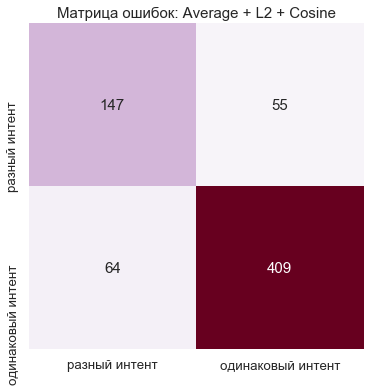

              precision    recall  f1-score   support

           0       0.70      0.73      0.71       202
           1       0.88      0.86      0.87       473

   micro avg       0.82      0.82      0.82       675
   macro avg       0.79      0.80      0.79       675
weighted avg       0.83      0.82      0.82       675



In [33]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

m = confusion_matrix(df.binary_tag, df.fasttext_3_tag)
sns.set(font_scale=1.2)
plt.figure(figsize = (6,6))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, 
            xticklabels=["разный интент", "одинаковый интент"], 
            yticklabels=["разный интент", "одинаковый интент"], 
            cmap="PuRd",
           annot_kws={"size": 15})
plt.title("Матрица ошибок: Average + L2 + Cosine", fontsize=15)
plt.show()

print(classification_report(df.binary_tag, df.fasttext_3_tag))

## Тестируем модель 2: Max-pooling + Cosine

In [53]:
import numpy as np
import skimage.measure

def max_pooling(word_vecs:list):
    matrix = np.array(word_vecs)
    pooled_vec = skimage.measure.block_reduce(matrix, (len(word_vecs),1), np.max)
    return pooled_vec[0]

In [54]:
len(queries) == len(df)

True

In [55]:
max_pooling_cosines = []

for q1, q2 in queries:
    vec1 = []
    vec2 = []
    for word in tokenize_query(q1):
        vec1.append(tok2vec[word])
    for word in tokenize_query(q2):
        vec2.append(tok2vec[word])
    vec1 = max_pooling(vec1)
    vec2 = max_pooling(vec2)
    max_pooling_cosines.append(similarity(vec1, vec2))

In [56]:
len(max_pooling_cosines) == len(df)

True

In [57]:
df["max_pooling_cosines"] = max_pooling_cosines

In [58]:
# сделаем разметку по заранее подобранному порогу 0.4
tag_1_indexes = df[df.max_pooling_cosines >= float(0.4)].index.tolist()
tags = []
for i in df.index:
    if i in tag_1_indexes:
        tags.append(1)
    else:
        tags.append(0) 

In [59]:
df["max_pooling"] = tags

In [60]:
print(classification_report(df.binary_tag, df.max_pooling))

              precision    recall  f1-score   support

           0       0.61      0.54      0.57       202
           1       0.81      0.85      0.83       473

   micro avg       0.76      0.76      0.76       675
   macro avg       0.71      0.70      0.70       675
weighted avg       0.75      0.76      0.75       675



## Тестируем модель 3: конкатенация усреднения и max pooling

In [61]:
len(tok2vec)

1883

In [63]:
similarities = []
for q1,q2 in tqdm(queries):
    aver_vec1 = model_f.get_sentence_vector(q1)
    aver_vec2 = model_f.get_sentence_vector(q2)
    vec1 = []
    vec2 = []
    for word in tokenize_query(q1):
        vec1.append(tok2vec[word])
    for word in tokenize_query(q2):
        vec2.append(tok2vec[word])
    max_vec1 = max_pooling(vec1)
    max_vec2 = max_pooling(vec2)
    
    vec_1 = np.concatenate((aver_vec1, max_vec1))
    vec_2 = np.concatenate((aver_vec2, max_vec2))
    similarities.append(similarity(vec_1, vec_2))

In [64]:
similarities[-5:]

[0.49413254857063293,
 0.8844316601753235,
 0.7442746162414551,
 0.6770100593566895,
 0.40269598364830017]

In [65]:
df["aver_max_cosines"] = similarities

# сделаем разметку по заранее подобранному порогу 0.4
tag_1_indexes = df[df.aver_max_cosines >= float(0.4)].index.tolist()
tags = []
for i in df.index:
    if i in tag_1_indexes:
        tags.append(1)
    else:
        tags.append(0) 

In [66]:
df["aver_max"] = tags

In [67]:
print(classification_report(df.binary_tag, df.aver_max))

              precision    recall  f1-score   support

           0       0.61      0.54      0.58       202
           1       0.81      0.85      0.83       473

   micro avg       0.76      0.76      0.76       675
   macro avg       0.71      0.70      0.71       675
weighted avg       0.75      0.76      0.76       675



## Тестируем модель 4: Hierarchical pooling

In [85]:
def hierarchical_pooling(word_vecs:list, n=2):
    matrix = np.array(word_vecs)
    n_tokens = matrix.shape[0]
    if n_tokens == 1:
        return matrix.squeeze(0)
    if n_tokens == n:
        matrix_mean = matrix.mean(0)
        return matrix_mean
    if n_tokens > n:
        new_matrix = []
        for i in range(n_tokens-n+1):
            needle = matrix[i:i+n]
            needle_mean = needle.mean(0)
            new_matrix.append(needle_mean)
        new_matrix = np.array(new_matrix)
        pooled_vec = skimage.measure.block_reduce(new_matrix, (len(new_matrix),1), np.max)
        return pooled_vec.squeeze(0)

In [69]:
hierarchical_cosines = []

for q1, q2 in queries:
    vec1 = []
    vec2 = []
    for word in tokenize_query(q1):
        vec1.append(tok2vec[word])
    for word in tokenize_query(q2):
        vec2.append(tok2vec[word])
    vec1 = hierarchical_pooling(vec1)
    vec2 = hierarchical_pooling(vec2)
    hierarchical_cosines.append(similarity(vec1, vec2))

In [70]:
hierarchical_cosines[:3]

[0.9437752366065979, 0.9381735324859619, 0.9131990075111389]

In [71]:
df["hierarchical_cosines"] = hierarchical_cosines

In [72]:
# сделаем разметку по заранее подобранному порогу 0.4
tag_1_indexes = df[df.hierarchical_cosines >= float(0.4)].index.tolist()
tags = []
for i in df.index:
    if i in tag_1_indexes:
        tags.append(1)
    else:
        tags.append(0) 

In [73]:
df["hier"] = tags

In [74]:
print(classification_report(df.binary_tag, df.hier))

              precision    recall  f1-score   support

           0       0.72      0.74      0.73       202
           1       0.89      0.88      0.88       473

   micro avg       0.83      0.83      0.83       675
   macro avg       0.80      0.81      0.80       675
weighted avg       0.84      0.83      0.83       675



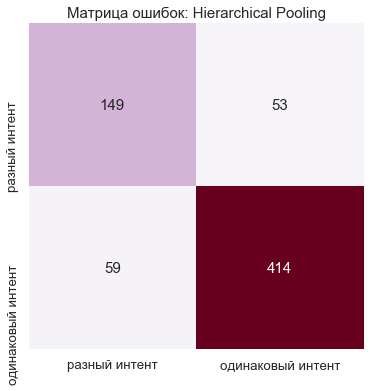

              precision    recall  f1-score   support

           0       0.72      0.74      0.73       202
           1       0.89      0.88      0.88       473

   micro avg       0.83      0.83      0.83       675
   macro avg       0.80      0.81      0.80       675
weighted avg       0.84      0.83      0.83       675



In [76]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

m = confusion_matrix(df.binary_tag, df.hier)
sns.set(font_scale=1.2)
plt.figure(figsize = (6,6))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, 
            xticklabels=["разный интент", "одинаковый интент"], 
            yticklabels=["разный интент", "одинаковый интент"], 
            cmap="PuRd",
           annot_kws={"size": 15})
plt.title("Матрица ошибок: Hierarchical Pooling", fontsize=15)
plt.show()

print(classification_report(df.binary_tag, df.hier))

## Тестируем модель 5: IDF + Aver + Cosine

In [77]:
from collections import defaultdict


# собираем idf-корпус из заголовков объявлений
freq_dict = defaultdict(int)
document_count = 0

prev_line = None

for line in tqdm(open("/Users/amnikolaeva/hse/diplom/fastText-0.9.1/cleaned_titles_full.txt", "r")):
    if line == prev_line:
        continue
    prev_line = line
    
    tokens = line.split()
    for t in tokens:
        freq_dict[t] += 1
        
    document_count += 1

In [78]:
len(freq_dict), document_count

(2485667, 54532823)

In [79]:
def idf(token):
    if freq_dict[token] == 0:            
        return -np.log10(1/document_count)
    else:
        return -np.log10(freq_dict[token]/document_count)

In [80]:
idf_cosines = []

for q1, q2 in queries:
    vec1 = []
    vec2 = []
    for word in tokenize_query(q1):
        vec = tok2vec[word]
        res = idf(word)
        vec1.append(res * vec)
        
    for word in tokenize_query(q2):
        vec = tok2vec[word]
        res = idf(word)
        vec2.append(res * vec)
        
    vec1 = sum(vec1)/len(vec1)
    vec2 = sum(vec2)/len(vec2)
    
    idf_cosines.append(similarity(vec1, vec2))

In [81]:
df["idf_cosines"] = idf_cosines

In [82]:
# сделаем разметку по заранее подобранному порогу 0.4
tag_1_indexes = df[df.idf_cosines >= float(0.4)].index.tolist()
tags = []
for i in df.index:
    if i in tag_1_indexes:
        tags.append(1)
    else:
        tags.append(0) 

In [83]:
df["idf"] = tags

In [84]:
print(classification_report(df.binary_tag, df.idf))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       202
           1       0.88      0.89      0.88       473

   micro avg       0.83      0.83      0.83       675
   macro avg       0.80      0.80      0.80       675
weighted avg       0.83      0.83      0.83       675

